In [2]:
#importo le librerie necessarie
import numpy as np
import pandas as pd

#definisco l'algoritmo come una classe
class Perceptron(object):
    
    #inizializzatore
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    #funzione per il fitting dei dati di training
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal (loc=0.0, scale=0.01, size=1+X.shape[1])
        
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    #funzione per calcolare il net input
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    #funzione per predire i valori delle y
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        

In [3]:
#import del dataset di training
dataset = pd.read_excel(r"C:\Users\fspadafora\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\Desktop\KAGGLE\spaceship-titanic\train_new.xlsx")

In [1]:
#import del dataset di test
#df_test = pd.read_excel(r"C:\Users\fspadafora\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\Desktop\KAGGLE\spaceship-titanic\test_new.xlsx")

In [4]:
#trasformo la variabile target da 0/1 a 1/-1
dataset['Transported'] = np.where(dataset['Transported'] == 0, -1, 1)

In [6]:
#standardizzo le variabili
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = scaler.fit_transform(df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])

#training
dataset[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T'
   ]] = scaler.fit_transform(dataset[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T']])

#test
#df_test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    #'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T'
   #]] = scaler.fit_transform(df_test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    #'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T']])

In [7]:
#preparo i vettori X e y di training
y_ = dataset.iloc[0:, 9].values
y = y_.reshape(len(y_), 1)
X1 = dataset.iloc[0:, 0:8].values
X2 = dataset.iloc[0:, 9:].values
X = np.concatenate((X1,X2), axis=1)

#preparo il vettore X di test
#X1t = df_test.iloc[0:, 0:8].values
#X2t = df_test.iloc[0:, 9:].values
#Xt = np.concatenate((X1t,X2t), axis=1)


In [8]:
#inizializzo un'istanza della classe Perceptron (ovvero dell'algoritmo)
p = Perceptron(0.01, 255, 1)

In [9]:
#lancio la funzione per il training del modello
p.fit(X, y)

In [10]:
#valuto lo score
score = 1 - (p.errors_[(len(p.errors_) - 1)] / dataset.shape[0])
score

0.6422408834694582

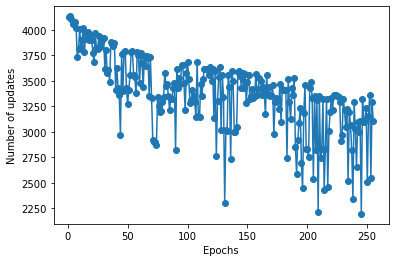

In [11]:
#plot the misclassification error for each epoch to check whether the algorithm converged and found a decision boundary
import matplotlib.pyplot as plt
plt.plot(range(1, len(p.errors_) + 1),
p.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [ ]:
#invoco la funzione predict per predire i valori di 'Transported' del Test set
#prediction = p.predict(Xt)